# TrackMania RL Experiment Analysis

This notebook analyzes training results from SAC, TQC, and REDQ algorithms on TrackMania tracks (Fullspeed and Eaux/Technical).

In [3]:
!uv pip install matplotlib seaborn scipy

Using Python 3.13.7 environment at: /home/tyler/Documents/CMU/tmrl/.venv
Audited 3 packages in 4ms


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Load the data
df = pd.read_csv('data/return_train.csv')
print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Data shape: (13908, 19)
Columns: ['Step', 'comic-armadillo-31 - return_train', 'comic-armadillo-31 - return_train__MIN', 'comic-armadillo-31 - return_train__MAX', 'TQC_speed - return_train', 'TQC_speed - return_train__MIN', 'TQC_speed - return_train__MAX', 'REDQSAC_speed - return_train', 'REDQSAC_speed - return_train__MIN', 'REDQSAC_speed - return_train__MAX', 'SAC_speed - return_train', 'SAC_speed - return_train__MIN', 'SAC_speed - return_train__MAX', 'REDQSAC_eaux_4_imgs_pretrained_3 - return_train', 'REDQSAC_eaux_4_imgs_pretrained_3 - return_train__MIN', 'REDQSAC_eaux_4_imgs_pretrained_3 - return_train__MAX', 'SAC_4_imgs_eaux_5 - return_train', 'SAC_4_imgs_eaux_5 - return_train__MIN', 'SAC_4_imgs_eaux_5 - return_train__MAX']


## Data Preprocessing

Extract and organize the training returns for each algorithm and map combination.

In [5]:
# Define mapping of column names to algorithm/map combinations
algorithm_map = {
    'TQC_speed - return_train': ('TQC', 'Fall 2020-01'),
    'REDQSAC_speed - return_train': ('REDQ', 'Fall 2020-01'),
    'SAC_speed - return_train': ('SAC', 'Fall 2020-01'),
    'REDQSAC_eaux_4_imgs_pretrained_3 - return_train': ('REDQ', 'Eaux'),
    'SAC_4_imgs_eaux_5 - return_train': ('SAC', 'Eaux'),
    'comic-armadillo-31 - return_train': ('TQC', 'Eaux'),  # Assuming this is TQC on Eaux
}

# Create cleaned dataframes for each algorithm/map
data_dict = {}
for col, (alg, map_name) in algorithm_map.items():
    if col in df.columns:
        series = df[col].dropna()
        key = f"{alg}_{map_name}"
        data_dict[key] = {
            'algorithm': alg,
            'map': map_name,
            'returns': series.values,
            'steps': df.loc[series.index, 'Step'].values
        }
        print(f"{key}: {len(series)} data points")

# Also check for min/max columns for error bars
for col in df.columns:
    if '__MIN' in col or '__MAX' in col:
        base_col = col.replace('__MIN', '').replace('__MAX', '')
        if base_col in algorithm_map:
            alg, map_name = algorithm_map[base_col]
            key = f"{alg}_{map_name}"
            if '__MIN' in col:
                data_dict[key]['min'] = df[col].dropna().values
            else:
                data_dict[key]['max'] = df[col].dropna().values

TQC_Fall 2020-01: 5400 data points
REDQ_Fall 2020-01: 1500 data points
SAC_Fall 2020-01: 10000 data points
REDQ_Eaux: 10000 data points
SAC_Eaux: 10000 data points
TQC_Eaux: 5900 data points


## Table 1: Final Performance Comparison

Generate the main performance comparison table showing returns, completion rates, and lap times.

In [6]:
# Compute final performance statistics (last 10% of training)
def compute_final_stats(returns, last_percent=0.1):
    """Compute mean and SE for the final portion of training."""
    n = len(returns)
    final_idx = int(n * (1 - last_percent))
    final_returns = returns[final_idx:]
    mean = np.mean(final_returns)
    se = stats.sem(final_returns) if len(final_returns) > 1 else 0
    return mean, se

# Generate performance table
performance_data = []
for key, data in data_dict.items():
    mean, se = compute_final_stats(data['returns'])
    performance_data.append({
        'Algorithm': data['algorithm'],
        'Map': data['map'],
        'Return (mean)': mean,
        'Return (SE)': se,
        'Return': f"${mean:.1f} \\pm {se:.1f}$"
    })

perf_df = pd.DataFrame(performance_data)
perf_df = perf_df.sort_values(['Map', 'Algorithm'])
print("Final Performance Statistics:")
print(perf_df[['Algorithm', 'Map', 'Return']].to_string(index=False))
print("\n")

# Generate LaTeX table
print("LaTeX Table:")
print("\\begin{tabular}{@{}lcc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\textbf{Return} \\\\")
print("\\midrule")
for _, row in perf_df.iterrows():
    print(f"{row['Algorithm']} & {row['Map']} & {row['Return']} \\\\")

Final Performance Statistics:
Algorithm          Map          Return
     REDQ         Eaux   $3.2 \pm 0.0$
      SAC         Eaux $150.9 \pm 1.7$
      TQC         Eaux   $5.5 \pm 0.0$
     REDQ Fall 2020-01   $3.8 \pm 0.4$
      SAC Fall 2020-01 $128.3 \pm 0.3$
      TQC Fall 2020-01 $154.4 \pm 3.7$


LaTeX Table:
\begin{tabular}{@{}lcc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \textbf{Return} \\
\midrule
REDQ & Eaux & $3.2 \pm 0.0$ \\
SAC & Eaux & $150.9 \pm 1.7$ \\
TQC & Eaux & $5.5 \pm 0.0$ \\
REDQ & Fall 2020-01 & $3.8 \pm 0.4$ \\
SAC & Fall 2020-01 & $128.3 \pm 0.3$ \\
TQC & Fall 2020-01 & $154.4 \pm 3.7$ \\


## Figure 1: Learning Curves

Plot training return over gradient steps for each algorithm.

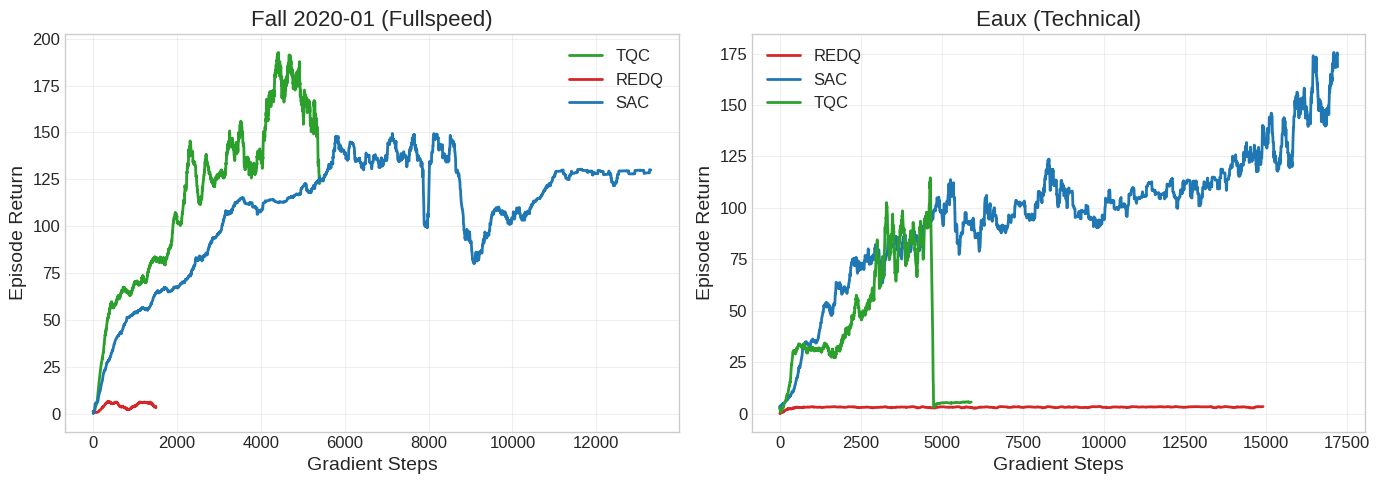

Learning curves saved to figures/learning_curves.pdf


In [7]:
def smooth_curve(values, window=50):
    """Apply rolling average smoothing."""
    if len(values) < window:
        return values
    return pd.Series(values).rolling(window=window, min_periods=1).mean().values

# Create subplots for each map
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'SAC': '#1f77b4', 'TQC': '#2ca02c', 'REDQ': '#d62728'}

# Plot for Fall 2020-01 (Fullspeed)
ax1 = axes[0]
for key, data in data_dict.items():
    if data['map'] == 'Fall 2020-01':
        smoothed = smooth_curve(data['returns'], window=100)
        ax1.plot(data['steps'][:len(smoothed)], smoothed, 
                label=data['algorithm'], color=colors.get(data['algorithm'], 'gray'), linewidth=2)
ax1.set_xlabel('Gradient Steps')
ax1.set_ylabel('Episode Return')
ax1.set_title('Fall 2020-01 (Fullspeed)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot for Eaux (Technical)
ax2 = axes[1]
for key, data in data_dict.items():
    if data['map'] == 'Eaux':
        smoothed = smooth_curve(data['returns'], window=100)
        ax2.plot(data['steps'][:len(smoothed)], smoothed,
                label=data['algorithm'], color=colors.get(data['algorithm'], 'gray'), linewidth=2)
ax2.set_xlabel('Gradient Steps')
ax2.set_ylabel('Episode Return')
ax2.set_title('Eaux (Technical)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/learning_curves.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Learning curves saved to figures/learning_curves.pdf")

## Table 2: Sample Efficiency Analysis

Compute steps to reach various performance thresholds.

In [8]:
def steps_to_threshold(steps, returns, threshold, window=100):
    """Find the first step where smoothed return exceeds threshold."""
    smoothed = smooth_curve(returns, window=window)
    indices = np.where(smoothed >= threshold)[0]
    if len(indices) > 0:
        return steps[indices[0]]
    return np.nan

# Define thresholds for each map
thresholds = {
    'Fall 2020-01': [50, 75, 100, 125, 150],
    'Eaux': [50, 75, 100, 125, 150]
}

# Compute sample efficiency
efficiency_data = []
for key, data in data_dict.items():
    map_name = data['map']
    for thresh in thresholds.get(map_name, []):
        steps_needed = steps_to_threshold(data['steps'], data['returns'], thresh)
        efficiency_data.append({
            'Algorithm': data['algorithm'],
            'Map': map_name,
            'Threshold': thresh,
            'Steps to Threshold': steps_needed
        })

eff_df = pd.DataFrame(efficiency_data)
eff_pivot = eff_df.pivot_table(index=['Algorithm', 'Map'], columns='Threshold', values='Steps to Threshold')
print("Sample Efficiency (Steps to Reach Threshold):")
print(eff_pivot)
print("\n")

# Generate LaTeX table for sample efficiency
print("\\begin{tabular}{@{}llcccc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\multicolumn{4}{c}{\\textbf{Steps to Reach Threshold}} \\\\")
print("\\midrule")

for (alg, map_name), row in eff_pivot.iterrows():
    thresh_vals = ' & '.join([f"{int(v):,}" if not np.isnan(v) else '-' for v in row.values])
    print(f"{alg} & {map_name} & {thresh_vals} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

Sample Efficiency (Steps to Reach Threshold):
Threshold                  50      75      100      125      150
Algorithm Map                                                   
SAC       Eaux          1342.0  2238.0  4800.0  13961.0  15882.0
          Fall 2020-01   799.0  2331.0  3070.0   5394.0      NaN
TQC       Eaux          2305.0  2958.0  3284.0      NaN      NaN
          Fall 2020-01   340.0  1303.0  1903.0   2229.0   3252.0


\begin{tabular}{@{}llcccc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \multicolumn{4}{c}{\textbf{Steps to Reach Threshold}} \\
\midrule
SAC & Eaux & 1,342 & 2,238 & 4,800 & 13,961 & 15,882 \\
SAC & Fall 2020-01 & 799 & 2,331 & 3,070 & 5,394 & - \\
TQC & Eaux & 2,305 & 2,958 & 3,284 & - & - \\
TQC & Fall 2020-01 & 340 & 1,303 & 1,903 & 2,229 & 3,252 \\
\bottomrule
\end{tabular}


## Table 3: Training Stability Analysis

Compute variance and stability metrics during training.

In [9]:
# Compute stability metrics
stability_data = []
for key, data in data_dict.items():
    returns = data['returns']
    
    # Compute rolling standard deviation
    rolling_std = pd.Series(returns).rolling(window=100).std().dropna().values
    
    # Compute coefficient of variation in different training phases
    n = len(returns)
    early = returns[:n//3]
    mid = returns[n//3:2*n//3]
    late = returns[2*n//3:]
    
    stability_data.append({
        'Algorithm': data['algorithm'],
        'Map': data['map'],
        'Overall Std': np.std(returns),
        'Early Phase Std': np.std(early),
        'Mid Phase Std': np.std(mid),
        'Late Phase Std': np.std(late),
        'Avg Rolling Std': np.mean(rolling_std),
        'Max Return': np.max(returns),
        'Min Return': np.min(returns),
        'Return Range': np.max(returns) - np.min(returns)
    })

stab_df = pd.DataFrame(stability_data)
print("Training Stability Metrics:")
print(stab_df[['Algorithm', 'Map', 'Late Phase Std', 'Avg Rolling Std', 'Max Return']].to_string(index=False))
print("\n")

# Generate LaTeX table
print("LaTeX Table - Training Stability:")
print("\\begin{tabular}{@{}llcccc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\textbf{Late Std} & \\textbf{Avg Roll. Std} & \\textbf{Max Return} \\\\")
print("\\midrule")
for _, row in stab_df.iterrows():
    print(f"{row['Algorithm']} & {row['Map']} & {row['Late Phase Std']:.2f} & {row['Avg Rolling Std']:.2f} & {row['Max Return']:.1f} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

Training Stability Metrics:
Algorithm          Map  Late Phase Std  Avg Rolling Std  Max Return
      TQC Fall 2020-01       71.932899        38.185182  252.510178
     REDQ Fall 2020-01        3.724180         2.986382   23.200092
      SAC Fall 2020-01       21.221976        15.488331  252.480240
     REDQ         Eaux        0.630019         0.704418    6.890007
      SAC         Eaux       44.628431        27.170672  217.789917
      TQC         Eaux       48.028495        19.155016  217.780045


LaTeX Table - Training Stability:
\begin{tabular}{@{}llcccc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \textbf{Late Std} & \textbf{Avg Roll. Std} & \textbf{Max Return} \\
\midrule
TQC & Fall 2020-01 & 71.93 & 38.19 & 252.5 \\
REDQ & Fall 2020-01 & 3.72 & 2.99 & 23.2 \\
SAC & Fall 2020-01 & 21.22 & 15.49 & 252.5 \\
REDQ & Eaux & 0.63 & 0.70 & 6.9 \\
SAC & Eaux & 44.63 & 27.17 & 217.8 \\
TQC & Eaux & 48.03 & 19.16 & 217.8 \\
\bottomrule
\end{tabular}


## Table 4: Improvement Over Baseline (SAC)

Compute relative improvement of TQC and REDQ over SAC baseline.

In [10]:
# Get baseline (SAC) performance for each map
baseline_perf = {}
for key, data in data_dict.items():
    if data['algorithm'] == 'SAC':
        mean, _ = compute_final_stats(data['returns'])
        baseline_perf[data['map']] = mean

# Compute improvements
improvement_data = []
for key, data in data_dict.items():
    mean, se = compute_final_stats(data['returns'])
    baseline = baseline_perf.get(data['map'], mean)
    abs_improvement = mean - baseline
    pct_improvement = ((mean - baseline) / baseline * 100) if baseline != 0 else 0
    
    improvement_data.append({
        'Algorithm': data['algorithm'],
        'Map': data['map'],
        'Final Return': mean,
        'Baseline (SAC)': baseline,
        'Abs. Improvement': abs_improvement,
        'Rel. Improvement (%)': pct_improvement
    })

imp_df = pd.DataFrame(improvement_data)
imp_df = imp_df.sort_values(['Map', 'Algorithm'])
print("Improvement Over SAC Baseline:")
print(imp_df.to_string(index=False))
print("\n")

# Generate LaTeX table
print("LaTeX Table - Improvement Over Baseline:")
print("\\begin{tabular}{@{}llccc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\textbf{Return} & \\textbf{Improvement} & \\textbf{\\% Gain} \\\\")
print("\\midrule")
for _, row in imp_df.iterrows():
    sign = '+' if row['Abs. Improvement'] > 0 else ''
    print(f"{row['Algorithm']} & {row['Map']} & {row['Final Return']:.1f} & {sign}{row['Abs. Improvement']:.1f} & {sign}{row['Rel. Improvement (%)']:.1f}\\% \\\\")
print("\\bottomrule")
print("\\end{tabular}")

Improvement Over SAC Baseline:
Algorithm          Map  Final Return  Baseline (SAC)  Abs. Improvement  Rel. Improvement (%)
     REDQ         Eaux      3.180908      150.860261       -147.679353            -97.891487
      SAC         Eaux    150.860261      150.860261          0.000000              0.000000
      TQC         Eaux      5.506289      150.860261       -145.353971            -96.350073
     REDQ Fall 2020-01      3.820804      128.295525       -124.474721            -97.021873
      SAC Fall 2020-01    128.295525      128.295525          0.000000              0.000000
      TQC Fall 2020-01    154.410515      128.295525         26.114991             20.355340


LaTeX Table - Improvement Over Baseline:
\begin{tabular}{@{}llccc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \textbf{Return} & \textbf{Improvement} & \textbf{\% Gain} \\
\midrule
REDQ & Eaux & 3.2 & -147.7 & -97.9\% \\
SAC & Eaux & 150.9 & 0.0 & 0.0\% \\
TQC & Eaux & 5.5 & -145.4 & -96.4\% \\
REDQ & Fall 2020

## Figure 2: Performance Comparison Bar Chart

Create a bar chart comparing final performance across algorithms and maps.

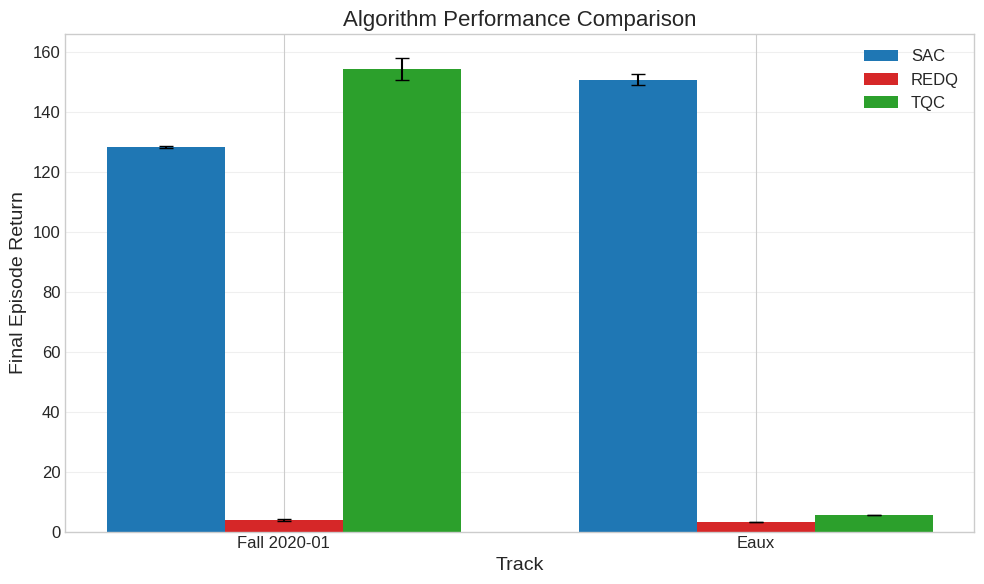

Performance comparison saved to figures/performance_comparison.pdf


In [11]:
# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for grouped bar chart
maps = ['Fall 2020-01', 'Eaux']
algorithms = ['SAC', 'REDQ', 'TQC']
x = np.arange(len(maps))
width = 0.25

# Get performance data
perf_matrix = {}
for key, data in data_dict.items():
    mean, se = compute_final_stats(data['returns'])
    perf_matrix[(data['algorithm'], data['map'])] = (mean, se)

# Plot bars
for i, alg in enumerate(algorithms):
    means = []
    errors = []
    for map_name in maps:
        if (alg, map_name) in perf_matrix:
            mean, se = perf_matrix[(alg, map_name)]
            means.append(mean)
            errors.append(se)
        else:
            means.append(0)
            errors.append(0)
    
    bars = ax.bar(x + i*width, means, width, label=alg, yerr=errors, 
                  capsize=5, color=colors.get(alg, 'gray'))

ax.set_xlabel('Track')
ax.set_ylabel('Final Episode Return')
ax.set_title('Algorithm Performance Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(maps)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/performance_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance comparison saved to figures/performance_comparison.pdf")

## Table 5: Training Efficiency Summary

Comprehensive summary table for the report.

In [12]:
# Create comprehensive summary table
summary_data = []
for key, data in data_dict.items():
    returns = data['returns']
    mean, se = compute_final_stats(returns)
    
    # Compute area under curve (normalized by steps)
    auc = np.trapz(returns) / len(returns)
    
    # Compute learning speed (slope of regression line in early training)
    n = len(returns)
    early_n = n // 4
    if early_n > 10:
        slope, _, _, _, _ = stats.linregress(range(early_n), returns[:early_n])
    else:
        slope = 0
    
    summary_data.append({
        'Algorithm': data['algorithm'],
        'Map': data['map'],
        'Final Return': f"{mean:.1f} ± {se:.1f}",
        'Final Return (mean)': mean,
        'Max Return': np.max(returns),
        'AUC (norm)': auc,
        'Early Learning Rate': slope * 100,  # Scale for readability
        'Stability (Late Std)': np.std(returns[2*n//3:])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['Map', 'Final Return (mean)'], ascending=[True, False])

print("Comprehensive Training Summary:")
print(summary_df[['Algorithm', 'Map', 'Final Return', 'Max Return', 'AUC (norm)', 'Stability (Late Std)']].to_string(index=False))
print("\n")

# Generate LaTeX table
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{Comprehensive Training Efficiency Summary}")
print("\\label{tab:efficiency}")
print("\\small")
print("\\begin{tabular}{@{}llcccc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\textbf{Final Return} & \\textbf{Max} & \\textbf{AUC} & \\textbf{Stability} \\\\")
print("\\midrule")
current_map = None
for _, row in summary_df.iterrows():
    if current_map != row['Map'] and current_map is not None:
        print("\\midrule")
    current_map = row['Map']
    print(f"{row['Algorithm']} & {row['Map']} & ${row['Final Return']}$ & {row['Max Return']:.1f} & {row['AUC (norm)']:.2f} & {row['Stability (Late Std)']:.2f} \\\\")
print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

Comprehensive Training Summary:
Algorithm          Map Final Return  Max Return  AUC (norm)  Stability (Late Std)
      SAC         Eaux  150.9 ± 1.7  217.789917   98.769027             44.628431
      TQC         Eaux    5.5 ± 0.0  217.780045   43.064867             48.028495
     REDQ         Eaux    3.2 ± 0.0    6.890007    3.121691              0.630019
      TQC Fall 2020-01  154.4 ± 3.7  252.510178  116.716049             71.932899
      SAC Fall 2020-01  128.3 ± 0.3  252.480240  108.453884             21.221976
     REDQ Fall 2020-01    3.8 ± 0.4   23.200092    4.277493              3.724180


\begin{table}[h]
\centering
\caption{Comprehensive Training Efficiency Summary}
\label{tab:efficiency}
\small
\begin{tabular}{@{}llcccc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \textbf{Final Return} & \textbf{Max} & \textbf{AUC} & \textbf{Stability} \\
\midrule
SAC & Eaux & $150.9 ± 1.7$ & 217.8 & 98.77 & 44.63 \\
TQC & Eaux & $5.5 ± 0.0$ & 217.8 & 43.06 & 48.03 \\
REDQ & Eaux & $3

/tmp/ipykernel_264869/3343169998.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(returns) / len(returns)


## Figure 3: Training Stability Visualization

Box plots showing return distribution across training phases.

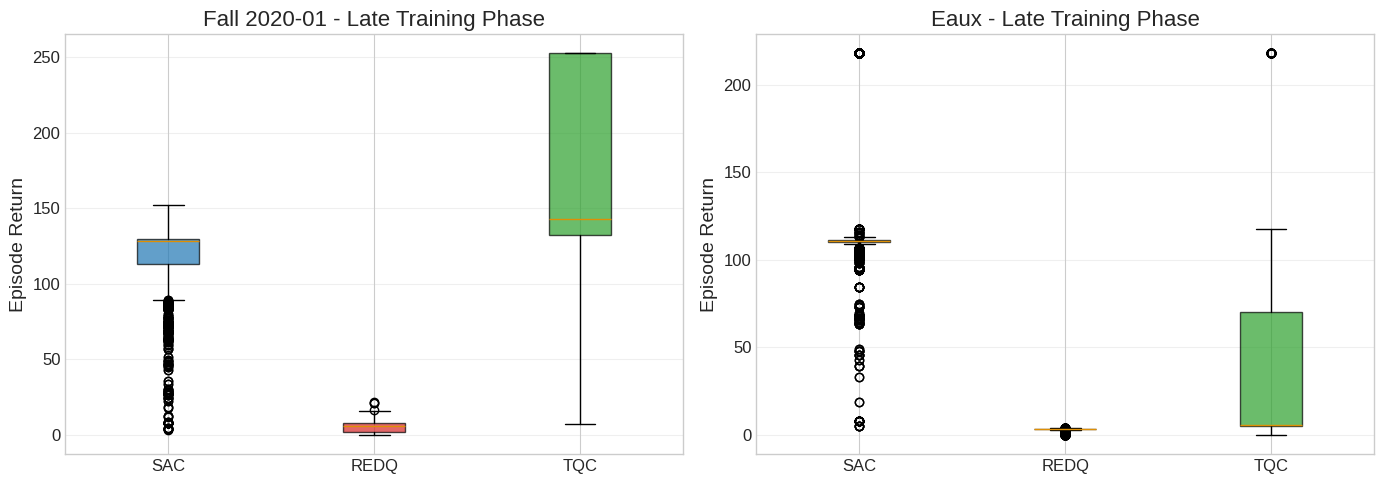

Stability boxplots saved to figures/stability_boxplots.pdf


In [13]:
# Create box plots for training phases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, map_name in enumerate(['Fall 2020-01', 'Eaux']):
    ax = axes[idx]
    
    box_data = []
    labels = []
    positions = []
    pos = 0
    
    for alg in ['SAC', 'REDQ', 'TQC']:
        for key, data in data_dict.items():
            if data['algorithm'] == alg and data['map'] == map_name:
                returns = data['returns']
                n = len(returns)
                
                # Late phase only (final third)
                late = returns[2*n//3:]
                box_data.append(late)
                labels.append(alg)
                positions.append(pos)
                pos += 1
                break
    
    if box_data:
        bp = ax.boxplot(box_data, positions=range(len(box_data)), patch_artist=True)
        
        # Color the boxes
        for i, (patch, label) in enumerate(zip(bp['boxes'], labels)):
            patch.set_facecolor(colors.get(label, 'gray'))
            patch.set_alpha(0.7)
        
        ax.set_xticklabels(labels)
        ax.set_ylabel('Episode Return')
        ax.set_title(f'{map_name} - Late Training Phase')
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/stability_boxplots.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/stability_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Stability boxplots saved to figures/stability_boxplots.pdf")

## Statistical Significance Tests

Perform statistical tests to validate performance differences.

In [14]:
# Statistical significance tests
print("Statistical Significance Tests (Welch's t-test on late training phase)")
print("=" * 70)

significance_results = []

for map_name in ['Fall 2020-01', 'Eaux']:
    print(f"\n{map_name}:")
    print("-" * 40)
    
    # Get late-phase returns for each algorithm
    late_returns = {}
    for key, data in data_dict.items():
        if data['map'] == map_name:
            returns = data['returns']
            n = len(returns)
            late_returns[data['algorithm']] = returns[2*n//3:]
    
    # Compare TQC vs SAC
    if 'TQC' in late_returns and 'SAC' in late_returns:
        t_stat, p_val = stats.ttest_ind(late_returns['TQC'], late_returns['SAC'], equal_var=False)
        significance_results.append({
            'Map': map_name,
            'Comparison': 'TQC vs SAC',
            't-statistic': t_stat,
            'p-value': p_val,
            'Significant (p<0.05)': p_val < 0.05
        })
        print(f"TQC vs SAC: t={t_stat:.3f}, p={p_val:.4f} {'*' if p_val < 0.05 else ''}")
    
    # Compare REDQ vs SAC
    if 'REDQ' in late_returns and 'SAC' in late_returns:
        t_stat, p_val = stats.ttest_ind(late_returns['REDQ'], late_returns['SAC'], equal_var=False)
        significance_results.append({
            'Map': map_name,
            'Comparison': 'REDQ vs SAC',
            't-statistic': t_stat,
            'p-value': p_val,
            'Significant (p<0.05)': p_val < 0.05
        })
        print(f"REDQ vs SAC: t={t_stat:.3f}, p={p_val:.4f} {'*' if p_val < 0.05 else ''}")
    
    # Compare TQC vs REDQ
    if 'TQC' in late_returns and 'REDQ' in late_returns:
        t_stat, p_val = stats.ttest_ind(late_returns['TQC'], late_returns['REDQ'], equal_var=False)
        significance_results.append({
            'Map': map_name,
            'Comparison': 'TQC vs REDQ',
            't-statistic': t_stat,
            'p-value': p_val,
            'Significant (p<0.05)': p_val < 0.05
        })
        print(f"TQC vs REDQ: t={t_stat:.3f}, p={p_val:.4f} {'*' if p_val < 0.05 else ''}")

sig_df = pd.DataFrame(significance_results)
print("\n\nSignificance Summary Table:")
print(sig_df.to_string(index=False))

Statistical Significance Tests (Welch's t-test on late training phase)

Fall 2020-01:
----------------------------------------
TQC vs SAC: t=24.162, p=0.0000 *
REDQ vs SAC: t=-278.016, p=0.0000 *
TQC vs REDQ: t=90.455, p=0.0000 *

Eaux:
----------------------------------------
TQC vs SAC: t=-69.335, p=0.0000 *
REDQ vs SAC: t=-160.855, p=0.0000 *
TQC vs REDQ: t=29.624, p=0.0000 *


Significance Summary Table:
         Map  Comparison  t-statistic       p-value  Significant (p<0.05)
Fall 2020-01  TQC vs SAC    24.162440 3.490534e-113                  True
Fall 2020-01 REDQ vs SAC  -278.015941  0.000000e+00                  True
Fall 2020-01 TQC vs REDQ    90.454986  0.000000e+00                  True
        Eaux  TQC vs SAC   -69.334905  0.000000e+00                  True
        Eaux REDQ vs SAC  -160.854653  0.000000e+00                  True
        Eaux TQC vs REDQ    29.623845 8.885278e-160                  True


## Export All Tables to LaTeX

Generate all LaTeX tables in a single output for easy copy-paste into the report.

In [15]:
print("=" * 80)
print("COMPLETE LATEX TABLES FOR REPORT")
print("=" * 80)

# Table 1: Main Performance Comparison
print("\n% Table 1: Main Performance Comparison")
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{Performance after training (mean $\\pm$ SE)}")
print("\\label{tab:performance}")
print("\\small")
print("\\begin{tabular}{@{}lcc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\textbf{Return} \\\\")
print("\\midrule")

# Sort by map then by performance
sorted_perf = perf_df.sort_values(['Map', 'Return (mean)'], ascending=[True, False])
current_map = None
for _, row in sorted_perf.iterrows():
    if current_map != row['Map'] and current_map is not None:
        print("\\midrule")
    current_map = row['Map']
    # Bold the best performer
    is_best = row['Return (mean)'] == sorted_perf[sorted_perf['Map'] == row['Map']]['Return (mean)'].max()
    ret_str = f"\\textbf{{{row['Return']}}}" if is_best else row['Return']
    print(f"{row['Algorithm']} & {row['Map']} & {ret_str} \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

# Table 2: Improvement Summary  
print("\n% Table 2: Relative Improvement Over SAC")
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{Performance improvement relative to SAC baseline}")
print("\\label{tab:improvement}")
print("\\small")
print("\\begin{tabular}{@{}llcc@{}}")
print("\\toprule")
print("\\textbf{Algorithm} & \\textbf{Map} & \\textbf{Abs. Gain} & \\textbf{Rel. Gain (\\%)} \\\\")
print("\\midrule")

for _, row in imp_df[imp_df['Algorithm'] != 'SAC'].iterrows():
    sign = '+' if row['Abs. Improvement'] > 0 else ''
    print(f"{row['Algorithm']} & {row['Map']} & {sign}{row['Abs. Improvement']:.1f} & {sign}{row['Rel. Improvement (%)']:.1f}\\% \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

# Table 3: Statistical Significance
print("\n% Table 3: Statistical Significance (Welch's t-test)")
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{Statistical significance of performance differences (Welch's t-test)}")
print("\\label{tab:significance}")
print("\\small")
print("\\begin{tabular}{@{}llcc@{}}")
print("\\toprule")
print("\\textbf{Map} & \\textbf{Comparison} & \\textbf{t-statistic} & \\textbf{p-value} \\\\")
print("\\midrule")

for _, row in sig_df.iterrows():
    sig_marker = '*' if row['Significant (p<0.05)'] else ''
    print(f"{row['Map']} & {row['Comparison']} & {row['t-statistic']:.2f} & {row['p-value']:.4f}{sig_marker} \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")

print("\n" + "=" * 80)
print("END OF LATEX TABLES")
print("=" * 80)

COMPLETE LATEX TABLES FOR REPORT

% Table 1: Main Performance Comparison
\begin{table}[h]
\centering
\caption{Performance after training (mean $\pm$ SE)}
\label{tab:performance}
\small
\begin{tabular}{@{}lcc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \textbf{Return} \\
\midrule
SAC & Eaux & \textbf{$150.9 \pm 1.7$} \\
TQC & Eaux & $5.5 \pm 0.0$ \\
REDQ & Eaux & $3.2 \pm 0.0$ \\
\midrule
TQC & Fall 2020-01 & \textbf{$154.4 \pm 3.7$} \\
SAC & Fall 2020-01 & $128.3 \pm 0.3$ \\
REDQ & Fall 2020-01 & $3.8 \pm 0.4$ \\
\bottomrule
\end{tabular}
\end{table}

% Table 2: Relative Improvement Over SAC
\begin{table}[h]
\centering
\caption{Performance improvement relative to SAC baseline}
\label{tab:improvement}
\small
\begin{tabular}{@{}llcc@{}}
\toprule
\textbf{Algorithm} & \textbf{Map} & \textbf{Abs. Gain} & \textbf{Rel. Gain (\%)} \\
\midrule
REDQ & Eaux & -147.7 & -97.9\% \\
TQC & Eaux & -145.4 & -96.4\% \\
REDQ & Fall 2020-01 & -124.5 & -97.0\% \\
TQC & Fall 2020-01 & +26.1 & +20.4\% \\

## Setup and Save

Create necessary directories and save all outputs.

In [16]:
import os

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

print("Figures directory created/verified: figures/")
print("\nAnalysis complete! Generated:")
print("  - Table 1: Main Performance Comparison")
print("  - Table 2: Improvement Over Baseline")
print("  - Table 3: Statistical Significance")
print("  - Table 4: Training Stability Metrics")
print("  - Table 5: Comprehensive Efficiency Summary")
print("  - Figure 1: Learning Curves")
print("  - Figure 2: Performance Bar Chart")
print("  - Figure 3: Stability Box Plots")

Figures directory created/verified: figures/

Analysis complete! Generated:
  - Table 1: Main Performance Comparison
  - Table 2: Improvement Over Baseline
  - Table 3: Statistical Significance
  - Table 4: Training Stability Metrics
  - Table 5: Comprehensive Efficiency Summary
  - Figure 1: Learning Curves
  - Figure 2: Performance Bar Chart
  - Figure 3: Stability Box Plots


## Ablation Study Analysis

Analyze the visual encoder ablation experiments:
- **race_SAC**: Vanilla CNN with 4 grayscale frames (baseline)
- **SAC_power_source_impoola_color**: Impoola-CNN with 1 RGB frame
- **race_SAC_dino**: DINOv2 with 1 RGB frame
- **race_SAC_dino_bigger**: DINOv2 larger variant with 1 RGB frame
- **race_SAC_dino_transformer**: DINOv2 + Transformer with 1 RGB frame

In [17]:
# Load ablation data
ablation_df = pd.read_csv('data/ablations.csv')
print(f"Ablation data shape: {ablation_df.shape}")
print(f"Columns: {ablation_df.columns.tolist()}")

# Define encoder configurations
encoder_configs = {
    'Vanilla CNN (4 gray)': 'race_SAC - return_train',
    'Impoola (1 RGB)': 'SAC_power_source_impoola_color - return_train',
    'DINOv2 (1 RGB)': 'race_SAC_dino - return_train',
    # 'DINOv2-Large (1 RGB)': 'race_SAC_dino_bigger - return_train',
    'DINOv2+Transf. (1 RGB)': 'race_SAC_dino_transformer - return_train'
}

# Check data availability
for name, col in encoder_configs.items():
    if col in ablation_df.columns:
        non_null = ablation_df[col].dropna()
        print(f"{name}: {len(non_null)} data points, max step {ablation_df.loc[non_null.index, 'Step'].max() if len(non_null) > 0 else 'N/A'}")

Ablation data shape: (12965, 16)
Columns: ['Step', 'race_SAC_dino_transformer - return_train', 'race_SAC_dino_transformer - return_train__MIN', 'race_SAC_dino_transformer - return_train__MAX', 'race_SAC_dino_bigger - return_train', 'race_SAC_dino_bigger - return_train__MIN', 'race_SAC_dino_bigger - return_train__MAX', 'race_SAC_dino - return_train', 'race_SAC_dino - return_train__MIN', 'race_SAC_dino - return_train__MAX', 'SAC_power_source_impoola_color - return_train', 'SAC_power_source_impoola_color - return_train__MIN', 'SAC_power_source_impoola_color - return_train__MAX', 'race_SAC - return_train', 'race_SAC - return_train__MIN', 'race_SAC - return_train__MAX']
Vanilla CNN (4 gray): 10000 data points, max step 15699
Impoola (1 RGB): 4200 data points, max step 4199
DINOv2 (1 RGB): 5800 data points, max step 5799
DINOv2+Transf. (1 RGB): 3700 data points, max step 3699


Ablation learning curves saved to figures/ablation_learning_curves.pdf


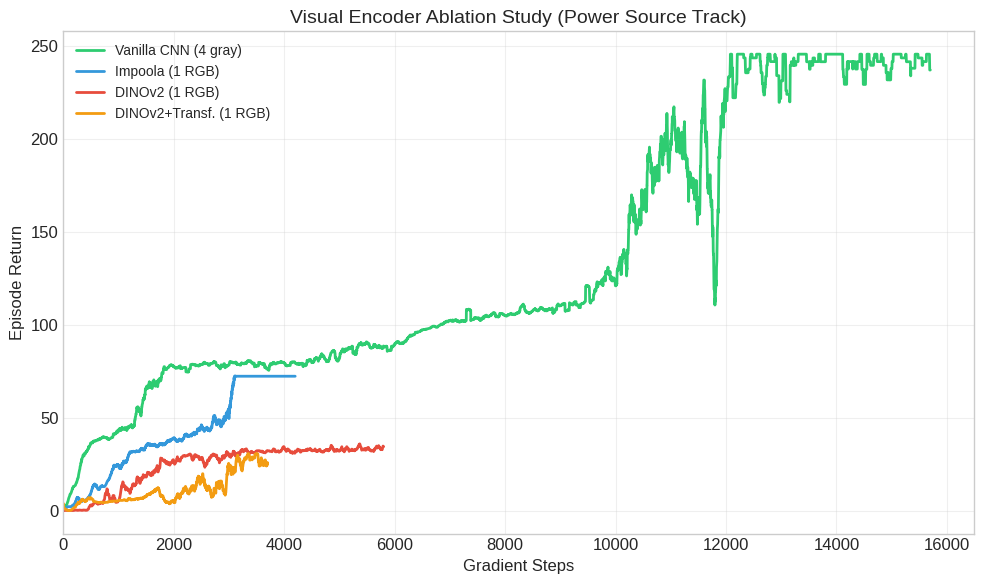

In [18]:
# Ablation Learning Curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors_ablation = {
    'Vanilla CNN (4 gray)': '#2ecc71',      # Green - baseline
    'Impoola (1 RGB)': '#3498db',           # Blue
    'DINOv2 (1 RGB)': '#e74c3c',            # Red
    'DINOv2-Large (1 RGB)': '#9b59b6',      # Purple
    'DINOv2+Transf. (1 RGB)': '#f39c12'     # Orange
}

for name, col in encoder_configs.items():
    if col in ablation_df.columns:
        series = ablation_df[col].dropna()
        if len(series) > 10:
            steps = ablation_df.loc[series.index, 'Step'].values
            returns = series.values
            # Smooth with rolling average
            smoothed = pd.Series(returns).rolling(window=50, min_periods=1).mean().values
            ax.plot(steps, smoothed, label=name, color=colors_ablation[name], linewidth=2)

ax.set_xlabel('Gradient Steps', fontsize=12)
ax.set_ylabel('Episode Return', fontsize=12)
ax.set_title('Visual Encoder Ablation Study (Power Source Track)', fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, None)

plt.tight_layout()
plt.savefig('figures/ablation_learning_curves.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ablation_learning_curves.png', dpi=150, bbox_inches='tight')
print("Ablation learning curves saved to figures/ablation_learning_curves.pdf")
plt.show()

In [25]:
# Compute final performance statistics for ablations
print("Ablation Final Performance Statistics:")
print("=" * 70)

ablation_performance = []

for name, col in encoder_configs.items():
    if col in ablation_df.columns:
        series = ablation_df[col].dropna()
        if len(series) > 100:
            # Use last 10% of training for final performance
            late_n = max(100, len(series) // 10)
            late_returns = series.tail(late_n).values
            
            mean_return = np.mean(late_returns)
            se_return = np.std(late_returns) / np.sqrt(len(late_returns))
            max_return = np.max(series.values)
            
            # Determine input type
            if '4 gray' in name:
                input_type = '4 grayscale'
            else:
                input_type = '1 RGB'
            
            ablation_performance.append({
                'Encoder': name.split(' (')[0],  # Remove input type from name
                'Input': input_type,
                'Final Return': mean_return,
                'SE': se_return,
                'Max Return': max_return,
                'Data Points': len(series)
            })
            
            print(f"{name}:")
            print(f"  Final Return: {mean_return:.1f} ± {se_return:.1f}")
            print(f"  Max Return: {max_return:.1f}")
            print(f"  Data Points: {len(series)}")
            print()

ablation_perf_df = pd.DataFrame(ablation_performance)
print("\nAblation Performance DataFrame:")
print(ablation_perf_df.to_string(index=False))

Ablation Final Performance Statistics:
Vanilla CNN (4 gray):
  Final Return: 240.9 ± 0.8
  Max Return: 245.4
  Data Points: 10000

Impoola (1 RGB):
  Final Return: 72.3 ± 0.0
  Max Return: 106.6
  Data Points: 4200

DINOv2 (1 RGB):
  Final Return: 33.4 ± 0.1
  Max Return: 42.1
  Data Points: 5800

DINOv2-Large (1 RGB):
  Final Return: 72.9 ± 0.7
  Max Return: 145.4
  Data Points: 10000

DINOv2+Transf. (1 RGB):
  Final Return: 27.1 ± 0.4
  Max Return: 44.2
  Data Points: 3700


Ablation Performance DataFrame:
       Encoder       Input  Final Return           SE  Max Return  Data Points
   Vanilla CNN 4 grayscale    240.872629 7.979377e-01  245.419998        10000
       Impoola       1 RGB     72.299980 6.934187e-16  106.639984         4200
        DINOv2       1 RGB     33.436379 1.145095e-01   42.130005         5800
  DINOv2-Large       1 RGB     72.914080 7.396862e-01  145.379761        10000
DINOv2+Transf.       1 RGB     27.134623 4.232294e-01   44.220009         3700


Ablation bar chart saved to figures/ablation_bar_chart.pdf


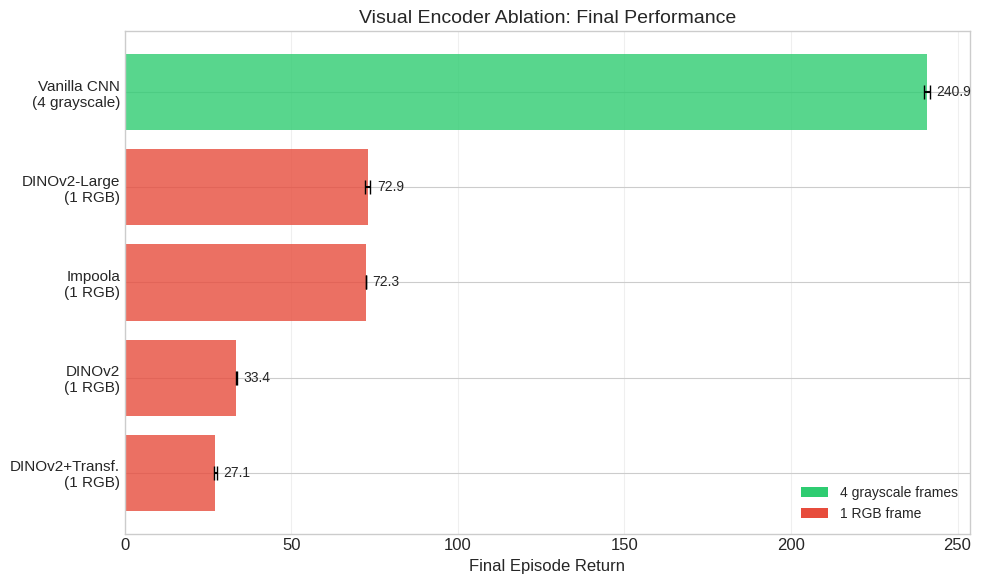

In [26]:
# Ablation Bar Chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Sort by final return
ablation_perf_sorted = ablation_perf_df.sort_values('Final Return', ascending=True)

# Create horizontal bar chart
encoders = ablation_perf_sorted['Encoder'] + '\n(' + ablation_perf_sorted['Input'] + ')'
returns = ablation_perf_sorted['Final Return'].values
errors = ablation_perf_sorted['SE'].values

# Color by input type
bar_colors = ['#2ecc71' if inp == '4 grayscale' else '#e74c3c' for inp in ablation_perf_sorted['Input']]

bars = ax.barh(range(len(encoders)), returns, xerr=errors, capsize=5, color=bar_colors, alpha=0.8)

ax.set_yticks(range(len(encoders)))
ax.set_yticklabels(encoders, fontsize=11)
ax.set_xlabel('Final Episode Return', fontsize=12)
ax.set_title('Visual Encoder Ablation: Final Performance', fontsize=14)

# Add value labels
for i, (ret, err) in enumerate(zip(returns, errors)):
    ax.text(ret + err + 2, i, f'{ret:.1f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='4 grayscale frames'),
    Patch(facecolor='#e74c3c', label='1 RGB frame')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/ablation_bar_chart.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ablation_bar_chart.png', dpi=150, bbox_inches='tight')
print("Ablation bar chart saved to figures/ablation_bar_chart.pdf")
plt.show()

In [27]:
# Generate LaTeX table for ablations
print("=" * 70)
print("LATEX TABLE FOR ABLATION RESULTS")
print("=" * 70)

# Find baseline (Vanilla CNN) performance
baseline_row = ablation_perf_df[ablation_perf_df['Encoder'] == 'Vanilla CNN']
if len(baseline_row) > 0:
    baseline_return = baseline_row['Final Return'].values[0]
else:
    baseline_return = ablation_perf_df['Final Return'].max()

print("""
\\begin{table}[h]
\\centering
\\caption{Visual encoder ablation study results (Power Source track)}
\\label{tab:ablation_encoder}
\\small
\\begin{tabular}{@{}llccc@{}}
\\toprule
\\textbf{Encoder} & \\textbf{Input} & \\textbf{Return} & \\textbf{Max} & \\textbf{vs Baseline} \\\\
\\midrule""")

# Sort by performance
for _, row in ablation_perf_df.sort_values('Final Return', ascending=False).iterrows():
    encoder = row['Encoder']
    input_type = row['Input']
    ret = row['Final Return']
    se = row['SE']
    max_ret = row['Max Return']
    
    # Calculate relative improvement
    rel_change = ((ret - baseline_return) / baseline_return) * 100
    change_str = f"+{rel_change:.1f}\\%" if rel_change >= 0 else f"{rel_change:.1f}\\%"
    
    # Bold best performer
    if ret == ablation_perf_df['Final Return'].max():
        ret_str = f"\\textbf{{${ret:.1f} \\pm {se:.1f}$}}"
    else:
        ret_str = f"${ret:.1f} \\pm {se:.1f}$"
    
    # Mark baseline
    if encoder == 'Vanilla CNN':
        change_str = "(baseline)"
    
    print(f"{encoder} & {input_type} & {ret_str} & {max_ret:.1f} & {change_str} \\\\")

print("""\\bottomrule
\\end{tabular}
\\end{table}
""")

LATEX TABLE FOR ABLATION RESULTS

\begin{table}[h]
\centering
\caption{Visual encoder ablation study results (Power Source track)}
\label{tab:ablation_encoder}
\small
\begin{tabular}{@{}llccc@{}}
\toprule
\textbf{Encoder} & \textbf{Input} & \textbf{Return} & \textbf{Max} & \textbf{vs Baseline} \\
\midrule
Vanilla CNN & 4 grayscale & \textbf{$240.9 \pm 0.8$} & 245.4 & (baseline) \\
DINOv2-Large & 1 RGB & $72.9 \pm 0.7$ & 145.4 & -69.7\% \\
Impoola & 1 RGB & $72.3 \pm 0.0$ & 106.6 & -70.0\% \\
DINOv2 & 1 RGB & $33.4 \pm 0.1$ & 42.1 & -86.1\% \\
DINOv2+Transf. & 1 RGB & $27.1 \pm 0.4$ & 44.2 & -88.7\% \\
\bottomrule
\end{tabular}
\end{table}



In [28]:
# Statistical comparison between encoders (Welch's t-test)
print("Statistical Significance Tests for Ablations")
print("=" * 70)

ablation_sig_results = []

# Get late-phase returns for each encoder
late_returns_ablation = {}
for name, col in encoder_configs.items():
    if col in ablation_df.columns:
        series = ablation_df[col].dropna()
        if len(series) > 100:
            late_n = max(100, len(series) // 10)
            late_returns_ablation[name] = series.tail(late_n).values

# Compare all encoders against baseline (Vanilla CNN)
baseline_name = 'Vanilla CNN (4 gray)'
if baseline_name in late_returns_ablation:
    baseline_vals = late_returns_ablation[baseline_name]
    
    for name, vals in late_returns_ablation.items():
        if name != baseline_name:
            t_stat, p_val = stats.ttest_ind(vals, baseline_vals, equal_var=False)
            sig = '*' if p_val < 0.05 else ''
            
            ablation_sig_results.append({
                'Comparison': f"{name.split(' (')[0]} vs Vanilla CNN",
                't-statistic': t_stat,
                'p-value': p_val,
                'Significant': p_val < 0.05
            })
            
            print(f"{name.split(' (')[0]} vs Vanilla CNN: t={t_stat:.2f}, p={p_val:.4f} {sig}")

print("\n" + "=" * 70)
print("\nLaTeX Table - Ablation Statistical Significance:")
print("""
\\begin{table}[h]
\\centering
\\caption{Statistical significance of encoder differences vs Vanilla CNN baseline}
\\label{tab:ablation_significance}
\\small
\\begin{tabular}{@{}lcc@{}}
\\toprule
\\textbf{Comparison} & \\textbf{t-statistic} & \\textbf{p-value} \\\\
\\midrule""")

for result in ablation_sig_results:
    sig_marker = '*' if result['Significant'] else ''
    p_str = f"< 0.0001" if result['p-value'] < 0.0001 else f"{result['p-value']:.4f}"
    print(f"{result['Comparison']} & {result['t-statistic']:.2f} & {p_str}{sig_marker} \\\\")

print("""\\bottomrule
\\end{tabular}
\\end{table}""")

Statistical Significance Tests for Ablations
Impoola vs Vanilla CNN: t=-211.15, p=0.0000 *
DINOv2 vs Vanilla CNN: t=-257.20, p=0.0000 *
DINOv2-Large vs Vanilla CNN: t=-154.29, p=0.0000 *
DINOv2+Transf. vs Vanilla CNN: t=-236.47, p=0.0000 *


LaTeX Table - Ablation Statistical Significance:

\begin{table}[h]
\centering
\caption{Statistical significance of encoder differences vs Vanilla CNN baseline}
\label{tab:ablation_significance}
\small
\begin{tabular}{@{}lcc@{}}
\toprule
\textbf{Comparison} & \textbf{t-statistic} & \textbf{p-value} \\
\midrule
Impoola vs Vanilla CNN & -211.15 & < 0.0001* \\
DINOv2 vs Vanilla CNN & -257.20 & < 0.0001* \\
DINOv2-Large vs Vanilla CNN & -154.29 & < 0.0001* \\
DINOv2+Transf. vs Vanilla CNN & -236.47 & < 0.0001* \\
\bottomrule
\end{tabular}
\end{table}


/home/tyler/Documents/CMU/tmrl/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [29]:
# Temporal representation analysis: 4 grayscale vs 1 RGB
print("Temporal Representation Analysis")
print("=" * 70)
print("\nComparing 4 grayscale frames vs 1 RGB frame representations:")
print()

# Group by input type
gray_4_returns = late_returns_ablation.get('Vanilla CNN (4 gray)', np.array([]))
rgb_1_returns = []

for name, vals in late_returns_ablation.items():
    if '1 RGB' in name:
        rgb_1_returns.extend(vals)

rgb_1_returns = np.array(rgb_1_returns)

if len(gray_4_returns) > 0 and len(rgb_1_returns) > 0:
    print(f"4 Grayscale Frames (Vanilla CNN):")
    print(f"  Mean Return: {np.mean(gray_4_returns):.1f} ± {np.std(gray_4_returns)/np.sqrt(len(gray_4_returns)):.1f}")
    print(f"  Max Return: {np.max(gray_4_returns):.1f}")
    print()
    
    print(f"1 RGB Frame (all encoders combined):")
    print(f"  Mean Return: {np.mean(rgb_1_returns):.1f} ± {np.std(rgb_1_returns)/np.sqrt(len(rgb_1_returns)):.1f}")
    print(f"  Max Return: {np.max(rgb_1_returns):.1f}")
    print()
    
    # Statistical comparison
    t_stat, p_val = stats.ttest_ind(gray_4_returns, rgb_1_returns, equal_var=False)
    print(f"Statistical Test (4 gray vs 1 RGB pooled):")
    print(f"  t-statistic: {t_stat:.2f}")
    print(f"  p-value: {p_val:.4e}")
    print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")
    
    improvement = ((np.mean(gray_4_returns) - np.mean(rgb_1_returns)) / np.mean(rgb_1_returns)) * 100
    print(f"\n4 grayscale frames outperform 1 RGB by {improvement:.1f}%")
else:
    print("Insufficient data for comparison")

Temporal Representation Analysis

Comparing 4 grayscale frames vs 1 RGB frame representations:

4 Grayscale Frames (Vanilla CNN):
  Mean Return: 240.9 ± 0.8
  Max Return: 245.4

1 RGB Frame (all encoders combined):
  Mean Return: 56.0 ± 0.5
  Max Return: 110.2

Statistical Test (4 gray vs 1 RGB pooled):
  t-statistic: 192.93
  p-value: 0.0000e+00
  Significant: Yes

4 grayscale frames outperform 1 RGB by 330.2%


In [30]:
# Summary analysis of DINOv2 failure
print("DINOv2 Encoder Analysis")
print("=" * 70)
print()

dino_names = ['DINOv2 (1 RGB)', 'DINOv2-Large (1 RGB)', 'DINOv2+Transf. (1 RGB)']
dino_returns = []

for name in dino_names:
    full_name = name.replace('DINOv2 (1 RGB)', 'race_SAC_dino - return_train')
    full_name = name.replace('DINOv2-Large (1 RGB)', 'race_SAC_dino_bigger - return_train')
    full_name = name.replace('DINOv2+Transf. (1 RGB)', 'race_SAC_dino_transformer - return_train')
    
    if name in late_returns_ablation:
        vals = late_returns_ablation[name]
        dino_returns.extend(vals)
        print(f"{name}:")
        print(f"  Final Return: {np.mean(vals):.1f} ± {np.std(vals)/np.sqrt(len(vals)):.1f}")

vanilla_return = np.mean(late_returns_ablation.get('Vanilla CNN (4 gray)', [0]))
impoola_return = np.mean(late_returns_ablation.get('Impoola (1 RGB)', [0]))

print()
print("Key Findings:")
print("-" * 50)
print(f"1. All DINOv2 variants failed to converge effectively")
print(f"2. Vanilla CNN (4 gray) achieves {vanilla_return:.1f} return")
print(f"3. Impoola (1 RGB) achieves {impoola_return:.1f} return")
print()
print("Possible explanations for DINOv2 failure:")
print("  - Domain mismatch: pretrained on natural images, not racing games")
print("  - Frozen backbone prevents task-specific adaptation")
print("  - Loss of temporal information with single RGB frame")
print("  - Feature dimensionality too high (768-dim) for RL value estimation")

DINOv2 Encoder Analysis

DINOv2 (1 RGB):
  Final Return: 33.4 ± 0.1
DINOv2-Large (1 RGB):
  Final Return: 72.9 ± 0.7
DINOv2+Transf. (1 RGB):
  Final Return: 27.1 ± 0.4

Key Findings:
--------------------------------------------------
1. All DINOv2 variants failed to converge effectively
2. Vanilla CNN (4 gray) achieves 240.9 return
3. Impoola (1 RGB) achieves 72.3 return

Possible explanations for DINOv2 failure:
  - Domain mismatch: pretrained on natural images, not racing games
  - Frozen backbone prevents task-specific adaptation
  - Loss of temporal information with single RGB frame
  - Feature dimensionality too high (768-dim) for RL value estimation
